In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
location="D:\s_chernov\AnacondaProjects\SberHouse\Data\\"
tr=pd.read_csv(location+"train.csv",sep=',')
tst=pd.read_csv(location+"test.csv",sep=',')

cheat=pd.read_csv(location+"sqprice.csv",sep=';')
prices=pd.read_csv(location+"dynamic_prices.csv",sep=';')


In [3]:
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

macro = pd.read_csv(location+"macro.csv", usecols=['timestamp'] + macro_cols)
macro.head()

,timestamp,balance_trade,balance_trade_growth,eurrub,average_provision_of_build_contract,micex_rgbi_tr,micex_cbi_tr,deposits_rate,mortgage_value,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build
0,2010-01-01,NaN,NaN,NaN,5.0,NaN,NaN,NaN,142968,13.72,30789.2,NaN,993.0,22825.0
1,2010-01-02,NaN,NaN,NaN,5.0,NaN,175.15,NaN,142968,13.72,30789.2,NaN,993.0,22825.0
2,2010-01-03,NaN,NaN,NaN,5.0,NaN,178.66,NaN,142968,13.72,30789.2,NaN,993.0,22825.0
3,2010-01-04,NaN,NaN,43.4054,5.0,NaN,183.44,NaN,142968,13.72,30789.2,NaN,993.0,22825.0
4,2010-01-05,NaN,NaN,42.9600,5.0,NaN,183.44,NaN,142968,13.72,30789.2,NaN,993.0,22825.0


In [4]:
from dateutil.parser import parse

dfDateTime=tr["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tr['year']=year
tr['month']=month
tr['day']=day

dfDateTime=tst["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tst['year']=year
tst['month']=month
tst['day']=day

dfDateTime=macro["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
macro['year']=year
macro['month']=month
macro['day']=day


In [5]:
macro['year_month']=map(lambda x,y:str(x)+"_"+str(y),macro.year,macro.month)
macro2=macro.loc[:,['year_month','micex_cbi_tr','eurrub','mortgage_rate']].groupby(['year_month']).mean()
macro2['year_month']=macro2.index
print macro2


            micex_cbi_tr     eurrub  mortgage_rate year_month
year_month                                                   
2010_1        178.836333  42.563157          13.72     2010_1
2010_10       190.704839  42.158577          13.22    2010_10
2010_11       190.641667  42.280430          12.75    2010_11
2010_12       191.142903  40.738913          12.61    2010_12
2010_2        182.361071  41.178407          13.93     2010_2
2010_3        184.232903  40.109948          13.64     2010_3
2010_4        185.319000  39.184667          13.42     2010_4
2010_5        185.331935  38.329561          13.41     2010_5
2010_6        187.974333  38.192767          13.41     2010_6
2010_7        188.841935  39.159297          13.32     2010_7
2010_8        189.113548  39.191787          13.16     2010_8
2010_9        190.015667  40.261990          13.30     2010_9
2011_1        198.184839  40.280884          12.45     2011_1
2011_10       203.691935  42.845948          11.57    2011_10
2011_11 

In [6]:
tr['year_month']=map(lambda x,y:str(x)+"_"+str(y),tr.year,tr.month)
tst['year_month']=map(lambda x,y:str(x)+"_"+str(y),tst.year,tst.month)

tr=pd.merge(tr, prices, how='left', on=['year_month', 'year_month'])
tst=pd.merge(tst, prices, how='left', on=['year_month', 'year_month'])

tr=pd.merge(tr, macro2, how='left', on=['year_month', 'year_month'])
tst=pd.merge(tst, macro2, how='left', on=['year_month', 'year_month'])

In [7]:
#tr=pd.concat([tr, cheat], axis=1, join='outer')
#tst=pd.concat([tr, cheat], axis=1, join='outer')


tr=pd.merge(tr, cheat, how='left', on=['sub_area', 'sub_area'])
tst=pd.merge(tst, cheat, how='left', on=['sub_area', 'sub_area'])

tr.loc[:,'cheat']=np.sqrt(tr.full_sq*tr.feb16+1)
tst.loc[:,'cheat']=np.sqrt(tst.full_sq*tst.feb16+1)





In [8]:
tr=tr.drop('timestamp',axis=1)
tst=tst.drop('timestamp',axis=1)

In [9]:
tr.material=np.int64(tr.material)
tst.material=np.int64(tst.material)

In [10]:
#features by type
response='price_doc'

tr_type=(tr.dtypes==np.float64)|(tr.dtypes==np.int64)
dig_features=list(tr.loc[:,tr_type].columns)
dig_features.remove(response)
tr_type=(tr.dtypes==np.object)
obj_features=list(tr.loc[:,tr_type].columns)

tr2=tr.loc[tr.year==2015]


In [11]:
# not finished building
a=tr2.build_year-tr2.year
a[(a.isnull())|(a<0)]=0
tr2['y_build']=a

a=tst.build_year-tst.year
a[(a.isnull())|(a<0)]=0
tst['y_build']=a

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
a=(tr2.y_build>0).apply(int)
tr2['flag_build']=a
a=(tst.y_build>0).apply(int)
tst['flag_build']=a

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
#___price and floor error

#print tst.loc[(tst.floor>tst.max_floor),['id','full_sq','floor','max_floor','sub_area']]

#_____price error
#print tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000),['id','full_sq','price_doc','sub_area']].index
tr2=tr2.drop( tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000)].index)

#___max_floor error
tr2=tr2.drop(tr2.loc[(tr2.floor>tr2.max_floor)].index)
correct=tst.loc[(tst.floor>tst.max_floor)].index
tst.loc[correct,'max_floor']=tst.floor[correct]+1
tr2=tr2.drop(tr2.loc[(tr2.num_room==0)].index)


In [14]:
#___square and num_room error
#print tr2.loc[(tr2.full_sq==64),['id','full_sq','num_room','price_doc','sub_area']]

tr2.loc[28867,'num_room']=1
tr2.loc[29172,'num_room']=2

tst.loc[464,'full_sq']=42
tst.loc[3500,'full_sq']=50
tst.loc[6350,'full_sq']=50
tst.loc[5383,'full_sq']=64
tst.loc[3174,'num_room']=1
tst.loc[6003,'num_room']=1
tst.loc[6181,'num_room']=2
tst.loc[7213,'num_room']=1
tst.loc[7313,'num_room']=1
tst.loc[1417,'num_room']=1
tst.loc[1429,'num_room']=1

#print tr2.loc[(tr2.full_sq/tr2.num_room<15),['id','full_sq','num_room','price_doc','sub_area']]
print tst.loc[(tst.full_sq/tst.num_room<15),['id','full_sq','num_room','sub_area']]


         id  full_sq  num_room            sub_area
2804  33278     14.8         1  Chertanovo Juzhnoe


In [15]:
#_________kitchen error

correct=tst.loc[(tst.kitch_sq/tst.full_sq>0.5)].index
tst.at[correct,'kitch_sq']=8

correct=tr2.loc[(tr.kitch_sq/tr.full_sq>0.5)].index
tr2.at[correct,'kitch_sq']=8

#print tst.loc[(tst.kitch_sq/tst.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]
#print tr2.loc[(tr2.kitch_sq/tr2.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]

#state error

tr2.at[tr2.state.isnull(),'state']=2
tst.at[tst.state.isnull(),'state']=2


In [16]:
#______last and first floor

tr2.loc[:,'first']=(tr2.floor==1).apply(int)
tr2.loc[:,'last']=(tr2.floor==tr2.max_floor).apply(int)
tst.loc[:,'first']=(tst.floor==1).apply(int)
tst.loc[:,'last']=(tst.floor==tst.max_floor).apply(int)


tr2.loc[:,'floor_low']=(tr2.floor<5).apply(int)
tst.loc[:,'floor_low']=(tst.floor<5).apply(int)

tr2.loc[:,'floor_5']=(tr2.floor==5).apply(int)
tst.loc[:,'floor_5']=(tst.floor==5).apply(int)

tr2.loc[:,'floor_9']=(tr2.floor==9).apply(int)
tst.loc[:,'floor_9']=(tst.floor==9).apply(int)

tr2.loc[:,'floor_12']=(tr2.floor==12).apply(int)
tst.loc[:,'floor_12']=(tst.floor==12).apply(int)

tr2.loc[:,'floor_13_18']=((tr2.max_floor>12) & (tr2.max_floor<=18)).apply(int)
tst.loc[:,'floor_13_18']=((tst.max_floor>12) & (tst.max_floor<=18)).apply(int)

tr2.loc[:,'floor_high']=(tr2.floor>18).apply(int)
tst.loc[:,'floor_high']=(tst.floor>15).apply(int)


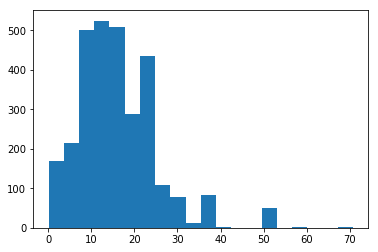

In [17]:
tr2.loc[:,'kremlin_near']=(tr2.kremlin_km<3).apply(int)
tst.loc[:,'kremlin_near']=(tst.kremlin_km<3).apply(int)

tr2.loc[:,'kremlin_1_5']=((tr2.kremlin_km>=1) & (tr2.kremlin_km<=5)).apply(int)
tst.loc[:,'kremlin_1_5']=((tst.kremlin_km>=1) & (tst.kremlin_km<=5)).apply(int)

tr2.loc[:,'kremlin_5_10']=((tr2.kremlin_km>5) & (tr2.kremlin_km<10)).apply(int)
tst.loc[:,'kremlin_5_10']=((tst.kremlin_km>5) & (tst.kremlin_km<10)).apply(int)


plt.hist(tr2.kremlin_km,20)
plt.show()

In [18]:
# month bool?
def make_dummies(pref,source,var_name):
    for i in var_name:
        dummies = pd.get_dummies(source[i],prefix=pref)
        source=pd.concat([source,dummies],axis=1)
    return source.drop(var_name,axis=1)

tr_back_up=tr2
tst_back_up=tst

tr2=make_dummies('mat',tr_back_up,['material'])
tst=make_dummies('mat',tst_back_up,['material'])



In [19]:
#ownership

tr2.loc[:,'own']=(tr2.product_type=='OwnerOccupier').apply(int)
tst.loc[:,'own']=(tst.product_type=='OwnerOccupier').apply(int)

#poselenie
#area_mo='Poselenie|Silino|Troickij okrug|Matushkino|Savelki|Severnoe|Vnukovo'
area_mo='Poselenie'


tr2.loc[:,'poselok']=tr2.sub_area.str.contains(area_mo).apply(int)
tst.loc[:,'poselok']=tst.sub_area.str.contains(area_mo).apply(int)

#radiation

tr2.loc[:,'radiate']=(tr2.radiation_raion=='yes').apply(int)
tst.loc[:,'radiate']=(tst.radiation_raion=='yes').apply(int)



In [20]:
tst.columns

Index([u'id', u'full_sq', u'life_sq', u'floor', u'max_floor', u'build_year',
       u'num_room', u'kitch_sq', u'state', u'product_type',
       ...
       u'kremlin_5_10', u'mat_1', u'mat_2', u'mat_3', u'mat_4', u'mat_5',
       u'mat_6', u'own', u'poselok', u'radiate'],
      dtype='object', length=321)

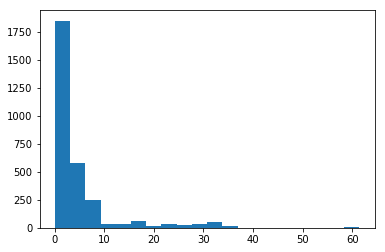

In [21]:
plt.hist((tr2.metro_min_avto),20)
plt.show()

#___metro features
tr2.loc[:,'metro_near']=(tr2.metro_min_avto<=3.4).apply(int)
tst.loc[:,'metro_near']=(tst.metro_min_avto<=3.4).apply(int)
tr2.loc[:,'metro_far']=(tr2.metro_min_avto>=20).apply(int)
tst.loc[:,'metro_far']=(tst.metro_min_avto>=20).apply(int)


In [22]:
from sklearn.model_selection import train_test_split


features=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','kremlin_near','kremlin_1_5','kremlin_5_10','mean_price',
          'own','metro_near','metro_far','poselok','radiate','indust_part','kindergarten_km',
          'mat_1','mat_2','mat_4','mat_5','mat_6']

features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','ttk_km','kremlin_1_5','indust_part','feb16','cheat',
          'own','metro_near','mean_price',
              'mat_1','mat_2','mat_4','mat_5',
             'green_zone_km','kindergarten_km','flag_build',
             'life_sq','build_year','public_healthcare_km','metro_min_avto',
             'workplaces_km','mosque_km','park_km','railroad'
             'micex_cbi_tr','eurrub','mortgage_rate']

features_pos=['num_room','full_sq','first','last',
          'floor_12','mkad_km','metro_min_avto','indust_part','mean_price','kindergarten_km','railroad_km',
             'mat_1','mat_2','mat_4','mat_5','y_build',
             'life_sq','build_year','max_floor','public_healthcare_km',
             'workplaces_km','mosque_km','park_km',
             'micex_cbi_tr','eurrub','mortgage_rate']

np.random.seed(123)



#y_train_mos=np.sqrt(y_train_mos)
#y_test_mos=np.sqrt(y_test_mos)

In [23]:
alph_regr=1
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
#poselok linear
#fit2= LinearRegression()


In [24]:
tr_pos=tr2[tr2.poselok==1]
tst_pos=tst[tst.poselok==1]

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(tr_pos.loc[:,features_pos], tr_pos.price_doc, test_size=0.33, random_state=42)

y_train_pos=np.sqrt(y_train_pos)
y_test_pos=np.sqrt(y_test_pos)



In [71]:

dtrain = xgb.DMatrix(X_train_pos, y_train_pos, feature_names=features_pos)
dval = xgb.DMatrix(X_test_pos, y_test_pos, feature_names=features_pos)
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

#partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

pred = partial_model.predict(dval)
print '________________'
print r2_score (y_test_pos,list(pred))
print len(pred),min(pred),max(pred)
print len(y_test_pos),min(y_test_pos),max(y_test_pos)

best_pos = partial_model.best_iteration
#partial_model.get_score()

[0]	val-rmse:2317.05
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:872.012
[40]	val-rmse:375.414
[60]	val-rmse:223.917
[80]	val-rmse:185.944
[100]	val-rmse:176.535
[120]	val-rmse:172.343
[140]	val-rmse:171.254
[160]	val-rmse:170.521
[180]	val-rmse:170.252
[200]	val-rmse:170
[220]	val-rmse:169.559
[240]	val-rmse:169.056
[260]	val-rmse:168.906
Stopping. Best iteration:
[255]	val-rmse:168.856

________________
0.865325283189
260 1390.4 3198.73
260 994.987437107 3878.56803473


In [73]:
tr_type=(tr.dtypes==np.float64)|(tr.dtypes==np.int64)
dig_features=list(tr.loc[:,tr_type].columns)
dig_features.remove(response)


In [74]:
tr_mos=tr2[(tr2.poselok==0)]
tst_mos=tst[tst.poselok==0]
#tr_mos=tr2[(tr2.poselok==0)&(tr2.month>1)]
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(tr_mos.loc[:,features_mos], tr_mos.price_doc, test_size=0.33, random_state=42)
y_train_mos=np.sqrt(y_train_mos)
y_test_mos=np.sqrt(y_test_mos)


In [76]:
dtrain = xgb.DMatrix(X_train_mos, y_train_mos, feature_names=features_mos)
dval = xgb.DMatrix(X_test_mos, y_test_mos, feature_names=features_mos)
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

#partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

pred = partial_model.predict(dval)
print '________________'
print r2_score (y_test_mos**2,pred**2)
#print r2_score (y_test_mos,pred)

print len(pred),min(pred),max(pred)
print len(y_test_mos),min(y_test_mos),max(y_test_mos)

best_mos = partial_model.best_iteration
#partial_model.get_score()

[0]	val-rmse:2840.23
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:1158.06
[40]	val-rmse:664.333
[60]	val-rmse:560.214
[80]	val-rmse:542.554
[100]	val-rmse:538.431
[120]	val-rmse:534.037
[140]	val-rmse:532.002
[160]	val-rmse:530.726
[180]	val-rmse:530.457
[200]	val-rmse:529.866
[220]	val-rmse:529.097
[240]	val-rmse:528.66
Stopping. Best iteration:
[233]	val-rmse:528.266

________________
0.736344122179
724 1484.11 6948.81
724 987.927122818 8366.60026534


In [77]:
#3BOOST for pos 
#fit = LinearRegression()
X=tr2.loc[tr2.poselok==1,features_pos]
Y=np.sqrt(tr2.loc[tr2.poselok==1,'price_doc'])
dtrain_all = xgb.DMatrix(X, Y, feature_names=features_pos)
dtest_all = xgb.DMatrix(tst.loc[tst.poselok==1,features_pos])


fit = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=best_pos)

pred_pos = fit.predict(dtest_all)
pred_pos=pred_pos**2
#pred_pos[pred_pos<900000]=900000

print len(pred_pos),min(pred_pos),max(pred_pos)
print len(Y),min(Y),max(Y)


1575 1.90228e+06 1.18115e+07
785 994.987437107 3878.56803473


In [78]:
#3BOOST for mos 
X=tr2.loc[tr2.poselok==0,features_mos]
#Y=np.sqrt(tr2.loc[tr2.poselok==0,'price_doc'])
Y=(tr2.loc[tr2.poselok==0,'price_doc'])

dtrain_all = xgb.DMatrix(X, Y, feature_names=features_mos)
dtest_all = xgb.DMatrix(tst.loc[tst.poselok==0,features_mos])

fit = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=best_mos)
pred_mos = fit.predict(dtest_all)
#pred_mos=pred_mos**2
#pred_mos[pred_mos<900000]=900000

print len(pred_mos),min(pred_mos),max(pred_mos)
print len(Y),min(Y),max(Y)

6087 2.0282e+06 4.77901e+07
2193 500000 95122496


In [79]:
res1=pd.DataFrame({'id':tst.loc[tst.poselok==1,'id'],'price_doc':(pred_pos)})
#print res1.describe()

res2=pd.DataFrame({'id':tst.loc[tst.poselok==0,'id'],'price_doc':(pred_mos)})
#print res2.describe()
res=pd.concat([res1,res2])
del res1,res2

In [80]:
#pd.DataFrame({'id':tst.id,'price_doc':(pred)}).to_csv(location+'submission.csv',sep=',',index=False)
res.to_csv(location+'submission2.csv',sep=',',index=False)


In [81]:
np.random.seed(123)


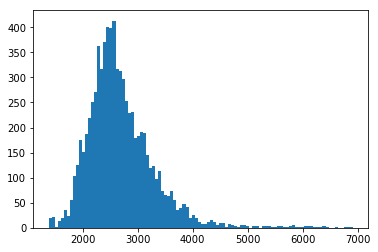

In [82]:
plt.hist(np.sqrt(res.price_doc),100)
plt.show()
